In [1]:
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

# Analysis

In [2]:
folder = "nodes_edges"
nodelists = sorted(glob.glob(os.path.join(folder, "*_nodelist.csv")))

# dictionary to store per-node metrics
node_metrics = {}

results = []

for nfile in nodelists:
    prefix = os.path.basename(nfile).replace("_nodelist.csv", "")
    efile = os.path.join(folder, f"{prefix}_edgelist.csv")

    nodes_df = pd.read_csv(nfile)
    edges_df = pd.read_csv(efile)
    edges = list(zip(edges_df["nodeID_from"], edges_df["nodeID_to"]))
    
    g = ig.Graph(edges=edges, directed=False)
    #g = g.components().giant()  # use giant component

    degrees = g.degree()
    betweenness = g.betweenness()

    #normalize betweenness
    betweenness_norm = np.array(betweenness) / ((g.vcount() - 1) * (g.vcount() - 2) / 2)

    # save per-node metrics in one dict
    node_metrics[prefix] = {"degree": degrees, "betweenness": betweenness_norm}

    # summary metrics
    metrics = {
        "network": prefix,
        "num_nodes": g.vcount(),
        "num_edges": g.ecount(),
        "assortativity": g.assortativity_degree(directed=False),
        "avg_path_length": g.average_path_length(directed=False),
        "avg_degree": sum(degrees)/len(degrees),
        "avg_betweenness": sum(betweenness_norm)/len(betweenness_norm)
    }
    results.append(metrics)

# summary table
results_df = pd.DataFrame(results)
print(results_df)


     network  num_nodes  num_edges  assortativity  avg_path_length  \
0  Barcelona        140        180       0.137231         7.853704   
1    Beijing        164        145       0.095857         9.592635   
2     Berlin        174        199       0.323213        12.459772   
3    Chicago        167        247       0.100818         7.737422   
4   HongKong        104         96       0.336282         9.431497   
5     London        333        408       0.296877        11.310512   
6     Madrid        306        250       0.204272        10.547387   
7     Mexico        148        164      -0.110467        11.006896   

   avg_degree  avg_betweenness  
0    2.571429         0.046857  
1    1.768293         0.031251  
2    2.287356         0.063603  
3    2.958084         0.040344  
4    1.846154         0.051255  
5    2.450450         0.019861  
6    1.633987         0.014628  
7    2.216216         0.067614  


## degree distrib and betweenness

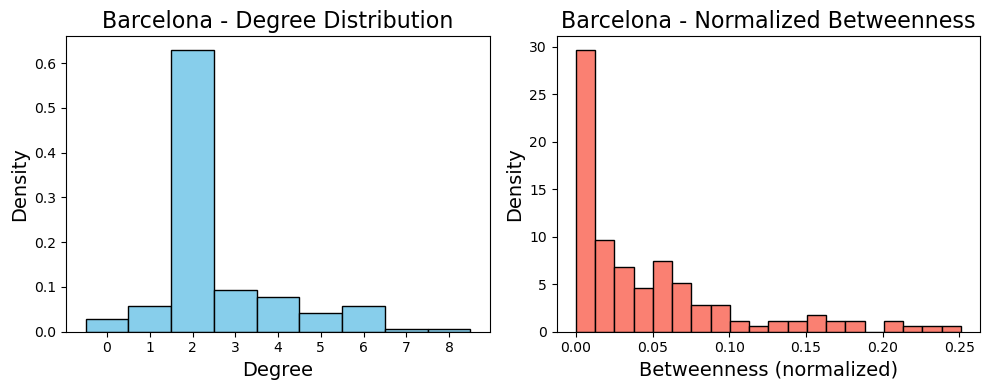

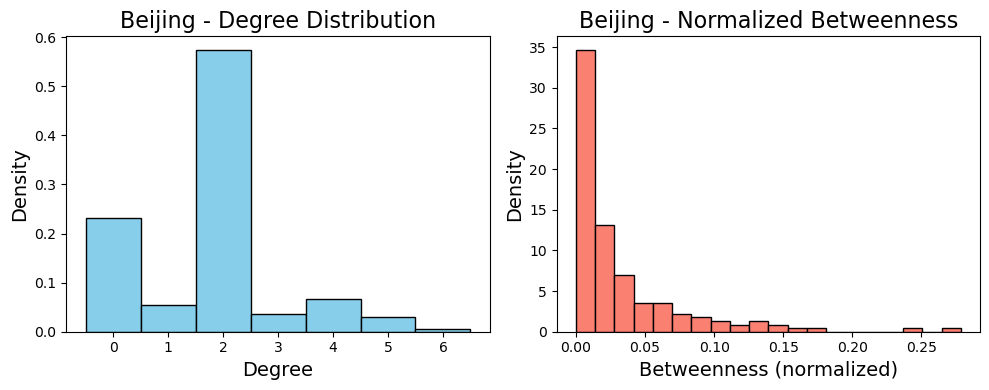

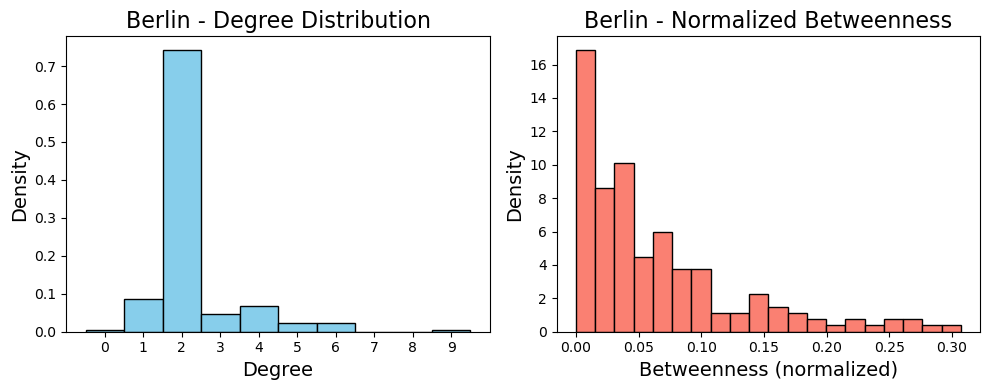

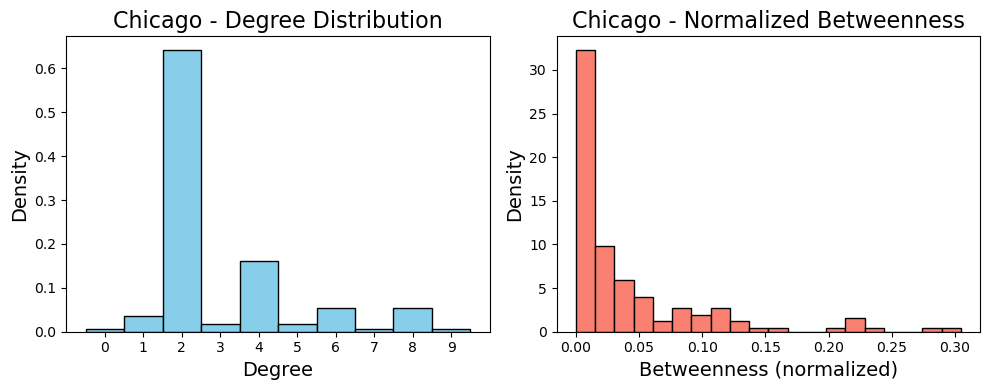

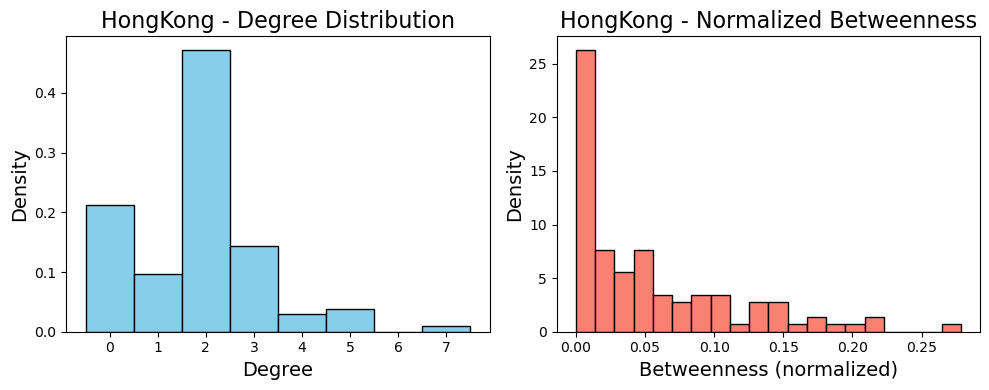

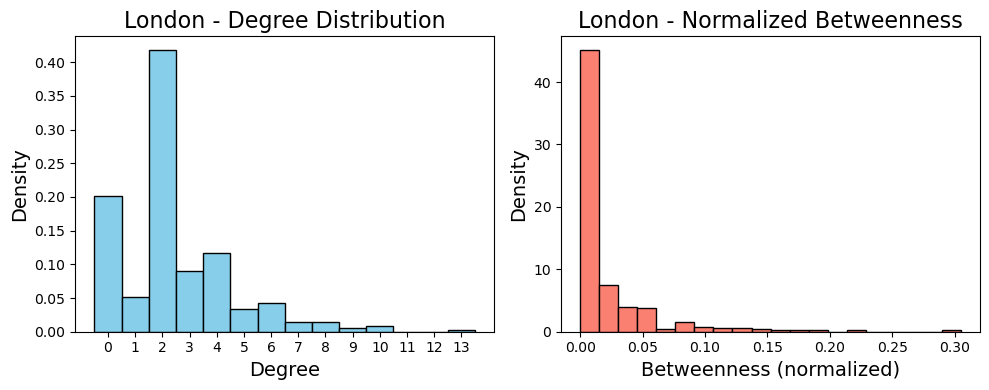

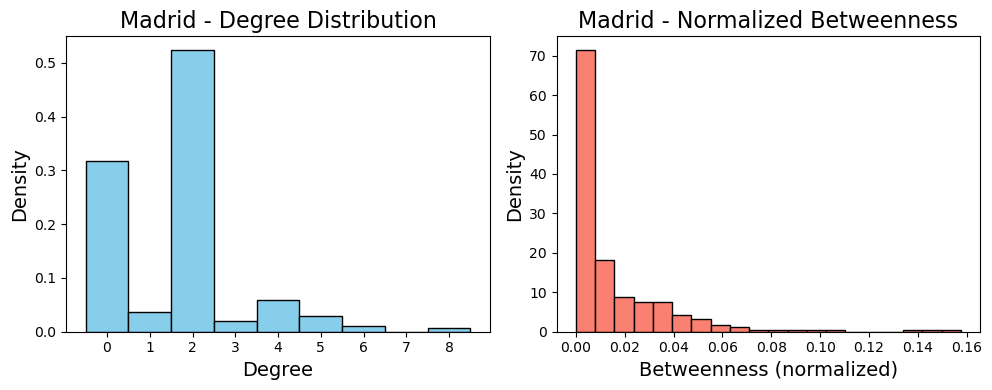

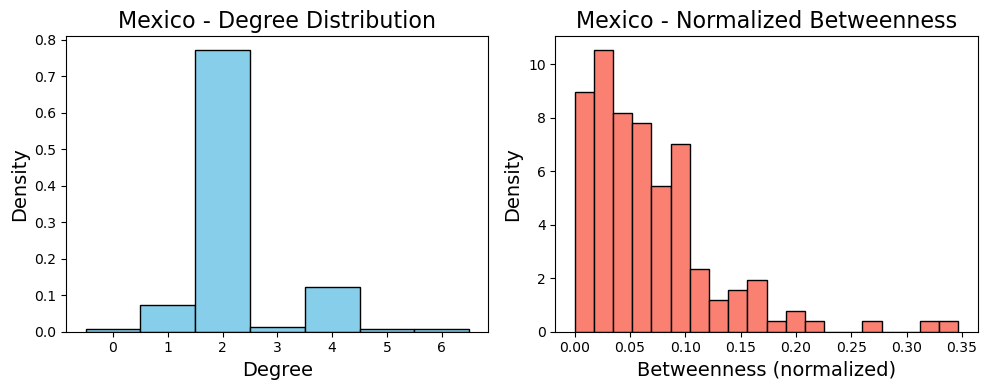

In [12]:
for network, data in node_metrics.items():
    degrees = np.array(data["degree"])
    betweenness = np.array(data["betweenness"])
    
    plt.figure(figsize=(10,4))
    
    # Degree distribution centered on integers
    plt.subplot(1,2,1)
    min_deg = degrees.min()
    max_deg = degrees.max()
    bins = np.arange(min_deg, max_deg + 2) - 0.5  # centers on integer values
    plt.hist(degrees, bins=bins, color='skyblue', edgecolor='k', density = True)
    plt.xticks(range(min_deg, max_deg+1))
    plt.title(f"{network} - Degree Distribution", fontsize = 16)
    plt.xlabel("Degree", fontsize = 14)
    plt.ylabel("Density", fontsize = 14)
    
    # Normalized betweenness distribution
    plt.subplot(1,2,2)
    plt.hist(betweenness, bins=20, density=True, color='salmon', edgecolor='k')
    plt.title(f"{network} - Normalized Betweenness", fontsize = 16)
    plt.xlabel("Betweenness (normalized)", fontsize = 14)
    plt.ylabel("Density", fontsize = 14)
    
    plt.tight_layout()
    plt.savefig(f"deg_bet_{network}.pdf")
    plt.show()

## Bar plots and correlation

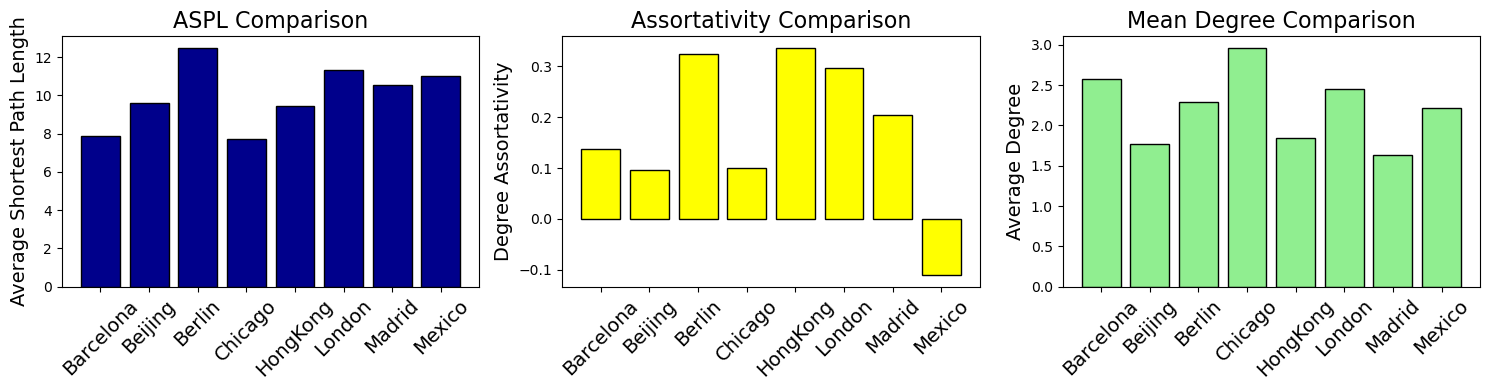

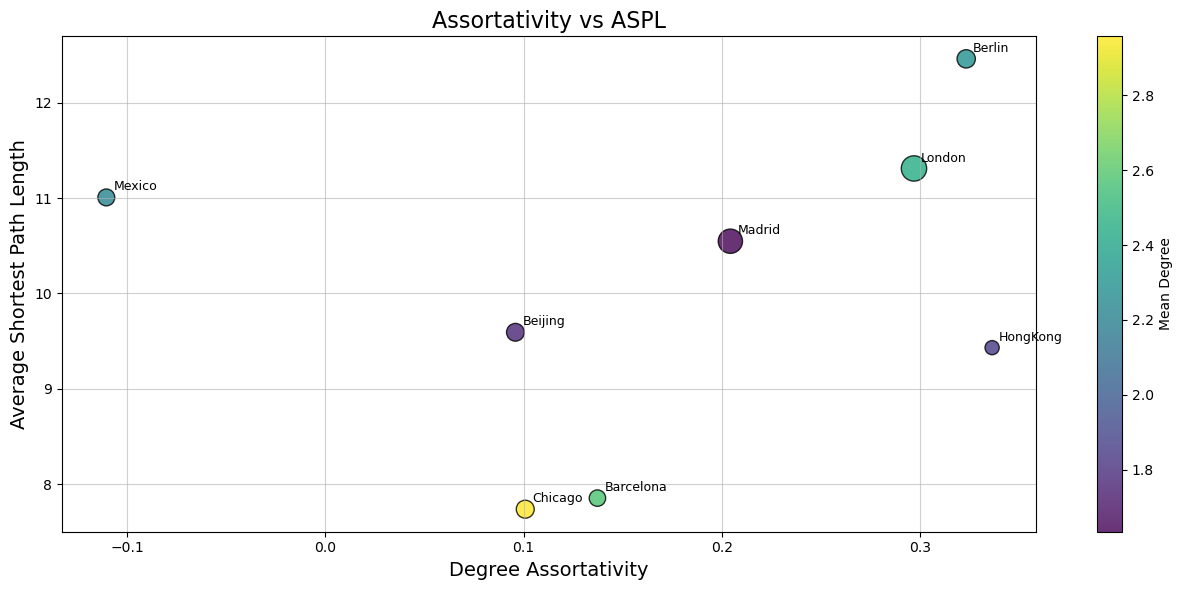

In [10]:
networks = results_df['network']
x_pos = np.arange(len(networks))

# --- 1. Bar plots ---
plt.figure(figsize=(15,4))

# ASPL
plt.subplot(1,3,1)
plt.bar(x_pos, results_df['avg_path_length'], color='darkblue', edgecolor='k')
plt.xticks(x_pos, networks, rotation=45, fontsize = 14)
plt.ylabel('Average Shortest Path Length', fontsize = 14)
plt.title('ASPL Comparison', fontsize = 16)

# Degree assortativity
plt.subplot(1,3,2)
plt.bar(x_pos, results_df['assortativity'], color='yellow', edgecolor='k')
plt.xticks(x_pos, networks, rotation=45, fontsize = 14)
plt.ylabel('Degree Assortativity', fontsize = 14)
plt.title('Assortativity Comparison', fontsize = 16)

# Average degree
plt.subplot(1,3,3)
plt.bar(x_pos, results_df['avg_degree'], color='lightgreen', edgecolor='k')
plt.xticks(x_pos, networks, rotation=45, fontsize = 14)
plt.ylabel('Average Degree', fontsize = 14)
plt.title('Mean Degree Comparison', fontsize = 16)

plt.tight_layout()
plt.savefig("comparison_plot.pdf")
plt.show()


# Correlation / scatter plot
plt.figure(figsize=(13,6))

sc = plt.scatter(
    results_df['assortativity'],
    results_df['avg_path_length'],
    s=results_df['num_nodes'],            # point size = network size
    c=results_df['avg_degree'],           # color = mean degree
    cmap='viridis',
    alpha=0.8,
    edgecolors='k'
)
plt.xlabel('Degree Assortativity', fontsize = 14)
plt.ylabel('Average Shortest Path Length', fontsize = 14)
plt.title('Assortativity vs ASPL', fontsize = 16)

# colorbar for mean degree
cbar = plt.colorbar(sc)
cbar.set_label('Mean Degree')

# annotate network names
for i, name in enumerate(results_df['network']):
    plt.annotate(name,
                 (results_df['assortativity'][i], results_df['avg_path_length'][i]),
                 xytext=(5,5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.grid(alpha=0.6)
plt.savefig("correlation_plot.pdf")
plt.show()
